<a href="https://colab.research.google.com/github/githubforkj/signate_studentcup2022/blob/main/students_cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [1]:
# signateとの連携

!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 49.7 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=80ef90cfb34b5c1ab5ab4edd08ef611d823479db735805a7500c0dd5ca16bcca
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
requests 2.23.0 requires urllib3!

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [2]:
# コンペのデータをダウンロード
!signate download --competition-id={735}


submit_sample.csv

Questionnaire.pdf

train.csv

test.csv


Download completed.


In [3]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 実装

### チュートリアル

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#学習用データと評価用データの読み込み
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [ ]:
#データのサイズ確認
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [ ]:
#学習用データの中身を確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [ ]:
#評価用データの中身を確認
test.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


4    505
1    468
3    455
2     88
Name: jobflag, dtype: int64


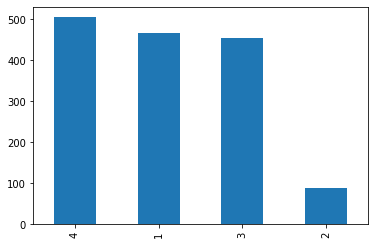

In [ ]:
#学習用データに含まれるjobflagをカウント（＋可視化）
print(train['jobflag'].value_counts())
train['jobflag'].value_counts().plot(kind = 'bar')

In [ ]:
#学習用データ, 評価用データのdescriptionに含まれる文字数を確認
train_length = train['description'].str.len()
test_length = test['description'].str.len()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


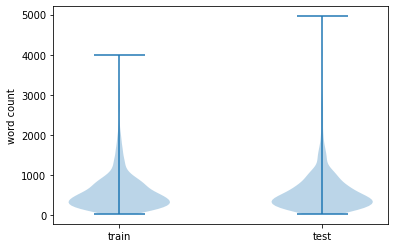

In [ ]:
#可視化
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([train_length, test_length])
ax.set_xticks([1, 2])
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('word count')
plt.show()

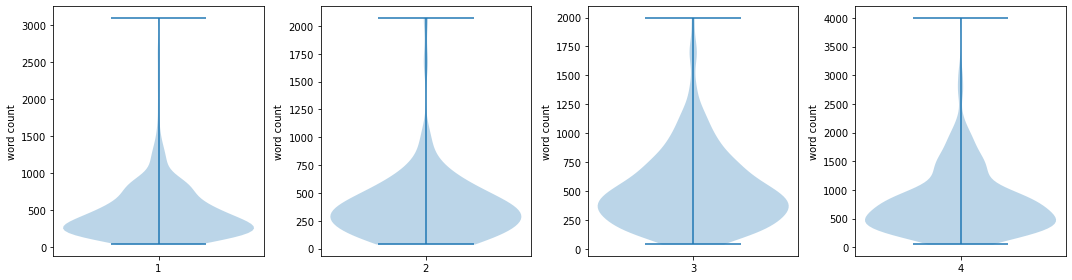

In [ ]:
#学習用データの職業ラベル(jobflag)ごとの文字数を確認
fig = plt.figure(figsize = (15, 4))
for flag in [1, 2, 3, 4]:
    train_length_flag = train[train['jobflag'] == flag]['description'].str.len()
    ax = fig.add_subplot(1, 4, flag)
    ax.violinplot(train_length_flag)
    ax.set_xticks([1])
    ax.set_xticklabels([flag])
    ax.set_ylabel('word count')
plt.tight_layout()
plt.show()

In [ ]:
#学習用データと評価用データを結合する (両データに対し一括で前処理を行うため)
combined = train.append(test, ignore_index=True)

In [ ]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する
# アルファベット以外の文字をスペースに置き換える
# 単語長が3文字以下のものは削除する
# ステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）

import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

combined_cleaned = combined.copy()
combined_cleaned['description'] = cleaning(combined['description'])

In [ ]:
# クリーニング結果の確認
print('#original\n', combined['description'][0])
print("-----")
print('#cleaned\n', combined_cleaned['description'][0])

#original
 <li>Develop cutting-edge web applications that perform superbly across all platforms.</li><li>Work in a highly collaborative environment with cross-functional teams on projects ranging from a few weeks to a few months in length.</li><li>Maintain high standard of quality as you creatively and strategically problem solve throughout the product delivery process.</li><li>Be able to effectively communicate your work with both technical and non-technical peers</li><li>Be excited about new web technologies/techniques</li><li>Build solid front-end architectures that integrate easily with other systems and technologies</li><li>Working closely with other disciplines (Back-end, UX, Design, QA)</li><li>Have a superior attention to detail and a strong ability to Q/A one\'s own work required, including cross-browser and cross-platform displays and performance</li></ul>
-----
#cleaned
 develop cut edg applic that perform superbl across platform work highli collabor environ with cross funct

In [ ]:
print(combined_cleaned.shape)
print(combined_cleaned.query('jobflag == 2'))
mljob2csv = combined_cleaned.query('jobflag == 2')
mljob2csv.to_csv("MLjobs.csv")

(3033, 3)
        id                                        description  jobflag
10      10  optim deep learn framework like tensorflow pyt...      2.0
13      13  research prototyp identifi build predict produ...      2.0
32      32  optim model method determin live real human fa...      2.0
47      47  work togeth with team perform research test ev...      2.0
68      68  implement appropri algorithmsresearch implemen...      2.0
...    ...                                                ...      ...
1450  1450                   build endpoint work cloud deploy      2.0
1474  1474  monitor diagnos maintain deploy upgrad system ...      2.0
1492  1492  implement appropri algorithm demonstr skill de...      2.0
1508  1508  defin problem opportun complex busi areameasur...      2.0
1512  1512  collabor with team support technic roadmap off...      2.0

[88 rows x 3 columns]


In [ ]:
print(combined_cleaned['description'][:3])

0    develop cut edg applic that perform superbl ac...
1    design develop high qualiti scalabl effici sol...
2    function point person network strategi work re...
Name: description, dtype: object


In [ ]:
#bag of words(文章中の単語の登場回数をカウントし, 特徴量化する手法)を用いて、descriptionをベクトル化する

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
bow = bow_vectorizer.fit_transform(combined_cleaned['description'])
print(bow)

  (0, 501)	1
  (0, 439)	1
  (0, 571)	1
  (0, 108)	1
  (0, 1246)	2
  (0, 1277)	2
  (0, 1977)	3
  (0, 819)	1
  (0, 310)	1
  (0, 623)	1
  (0, 426)	3
  (0, 753)	1
  (0, 1781)	1
  (0, 1353)	1
  (0, 1404)	1
  (0, 1959)	1
  (0, 1109)	1
  (0, 1028)	1
  (0, 816)	1
  (0, 1693)	1
  (0, 1389)	1
  (0, 419)	1
  (0, 1715)	1
  (0, 1335)	1
  (0, 1648)	1
  :	:
  (3031, 1513)	1
  (3031, 1205)	1
  (3031, 1013)	1
  (3031, 167)	1
  (3031, 1873)	1
  (3031, 890)	1
  (3031, 393)	1
  (3031, 1015)	1
  (3031, 1749)	1
  (3031, 1640)	1
  (3032, 1246)	1
  (3032, 623)	1
  (3032, 1789)	1
  (3032, 1901)	1
  (3032, 231)	1
  (3032, 1756)	2
  (3032, 1839)	1
  (3032, 924)	2
  (3032, 1473)	3
  (3032, 859)	1
  (3032, 1900)	1
  (3032, 156)	1
  (3032, 38)	1
  (3032, 1303)	1
  (3032, 899)	1


In [ ]:
#学習用データを分割して, 投稿前の精度検証を行う

from sklearn.model_selection import train_test_split

delimit_num = train.shape[0]
train_bow = bow[:delimit_num, :]
test_bow = bow[delimit_num:, :]

x_bow_train, x_bow_valid, y_bow_train, y_bow_valid = train_test_split(train_bow, train['jobflag'], test_size=0.3, random_state=0)

#### 学習・予測の部分を変更

In [ ]:
#XGBを用いて分類器を作成し、学習・予測を行う　1回目

# from xgboost import XGBClassifier

# mod = XGBClassifier(max_depth=6, n_estimators=1000, n_jobs=-1)
# mod.fit(x_bow_train, y_bow_train)
# pred = mod.predict(x_bow_valid)

In [ ]:
# SVMで分類器を作成する 2回目(rbf) 4回目(linear)

from sklearn.svm import SVC
mod = SVC(C=000.1,kernel='linear')
mod.fit(x_bow_train, y_bow_train)
pred = mod.predict(x_bow_valid)

In [ ]:
# k近傍法 3回目←びみょい

# from sklearn.neighbors import KNeighborsClassifier

# mod = KNeighborsClassifier(n_neighbors=4, p=2)
# mod.fit(x_bow_train, y_bow_train)
# pred = mod.predict(x_bow_valid)

              precision    recall  f1-score   support

           1      0.622     0.781     0.693       137
           2      0.500     0.273     0.353        22
           3      0.811     0.770     0.790       139
           4      0.784     0.694     0.736       157

    accuracy                          0.723       455
   macro avg      0.679     0.629     0.643       455
weighted avg      0.730     0.723     0.721       455



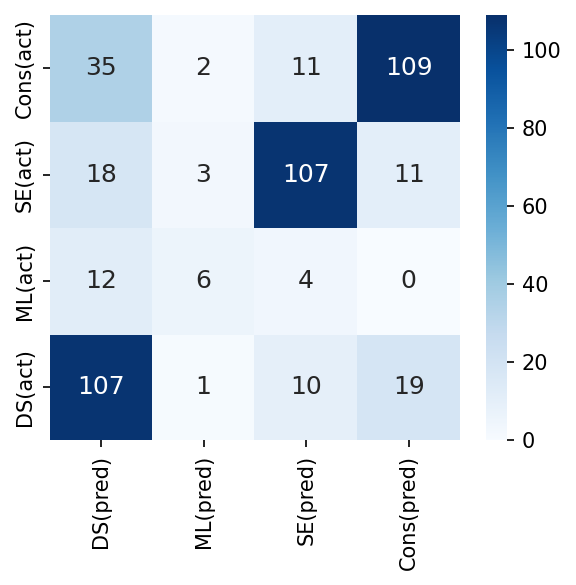

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(y_bow_valid, pred, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(y_bow_valid, pred, labels=labels, digits=3))

In [ ]:
# グリッドサーチでハイパーパラメータのチューニング

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = SVC(random_state=1)
param_range = [0.001,0.01,0.1,1,10,100]
param_grid = [{'C':param_range, 'kernel':['linear']},{'C':param_range, 'gamma':param_range,'kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='f1',cv=10,n_jobs=-1)
gs = gs.fit(x_bow_train, y_bow_train)
print(gs.best_score_)
print(gs.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  category=UserWarning,


nan
{'C': 0.001, 'kernel': 'linear'}


In [ ]:
mod.fit(train_bow, train['jobflag'])
pred_sub = mod.predict(test_bow)

In [ ]:
sample_submit_df = pd.DataFrame([test['id'], pred_sub]).T
sample_submit_df.to_csv('./sample.csv', header=None, index=None)

In [ ]:
# 提出
# !signate submit --competition-id=735 ./sample.csv --note 線形のSVMを使用

You have successfully submitted your predictions.We will send you the submission result to your email address.




1.   文字列を整形する
    1. 正規表現？
    1. htmlパーサー？
1.   テキスト集合から特徴量を抽出するアルゴリズムを適用
    1. bag-of-words?
    1. word2vec?
    1. BERT??
1. 学習用データを分割して交差検証を行う
    1. 学習データを7:3くらいで学習データ:検証データに分割する
    1. ＊＊＊いくつかあった方法を試す！
1. 分類器を作成する
    1. 学習する
    1. 予測する
1. 検証する
    1. テストデータセットで検証する




## BERT

- https://www.tensorflow.org/text/tutorials/classify_text_with_bert


### Settings

In [13]:
# install
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.6 MB 32.7 MB/s 
     |████████████████████████████████| 511.7 MB 6.4 kB/s 
     |████████████████████████████████| 5.8 MB 58.0 MB/s 
     |████████████████████████████████| 1.6 MB 64.5 MB/s 
     |████████████████████████████████| 438 kB 65.1 MB/s 
     |████████████████████████████████| 127 kB 55.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
signate 0.9.9 requires urllib3>=1.26.7, but you have urllib3 1.25.11 which is incompatible.


In [15]:
# ライブラリのインポート

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization # to create AdamW optimizer
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tf.get_logger().setLevel('ERROR')

In [5]:
#学習用データと評価用データの読み込み
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [6]:
#データのサイズ確認
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [7]:
# 学習データの確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [8]:
# テストデータの確認
test.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


### Preprocessing

In [9]:
#学習用データと評価用データを結合する (両データに対し一括で前処理を行うため)
combined = train.append(test, ignore_index=True)

In [10]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する
# アルファベット以外の文字をスペースに置き換える
# 単語長が3文字以下のものは削除する
# ステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）

import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

combined_cleaned = combined.copy()
combined_cleaned['description'] = cleaning(combined['description'])

In [11]:
print(combined_cleaned['description'])

0       develop cut edg applic that perform superbl ac...
1       design develop high qualiti scalabl effici sol...
2       function point person network strategi work re...
3       work technic design develop releas deploy clou...
4       quantifi resourc requir task project relat ent...
                              ...                        
3028    manag develop interfac requir interfac specif ...
3029    lead implement statist model capabl which requ...
3030    configur zuora fulfil casesidentifi area compl...
3031    gather translat document stakehold requir dema...
3032    support busi intellig environ use cogno other ...
Name: description, Length: 3033, dtype: object


In [17]:
# raw_train_data
print(train)

# raw_test_data
print(test)

        id                                        description  jobflag
0        0  <li>Develop cutting-edge web applications that...        3
1        1  <li> Designs and develops high quality, scalab...        3
2        2  <li>Functions as a point person for Network St...        4
3        3  <li> Work on the technical design, development...        3
4        4  <li>Quantify the resources required for a task...        4
...    ...                                                ...      ...
1511  1511  <li>Support detailed reporting, statistical an...        1
1512  1512  <li>Collaborate with teams to support the ML t...        2
1513  1513  <li> Work with executives and other business l...        1
1514  1514  <li>Leading design ideation sessions to ensure...        3
1515  1515  <li>Detection of Issues &amp; Impact Assessmen...        1

[1516 rows x 3 columns]
        id                                        description
0     1516  <li>Building decision-making models and propos...

In [61]:
# 学習データをさらに、学習用：検証用=8:2に分割する
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train,test_size=0.2,random_state=42)

print(train_df)
print(train_df.dtypes)
# print(val_df.shape)

        id                                        description  jobflag
1280  1280  <li>Participates in standard business and tech...        3
1334  1334  <li>Drive innovative applications of the knowl...        1
601    601  <li>Develop models, using C++, Python, and SQL...        1
590    590  <li>Collaborate with product management to und...        3
718    718  <li>Proficient use of recruiting tools and mat...        4
...    ...                                                ...      ...
1130  1130  <li>Independently identify issues, develop str...        1
1294  1294  <li>Build internal and external timelines and ...        1
860    860  <li>Support and improve our recommendation pip...        2
1459  1459  <li>Design and lead strategic business initiat...        4
1126  1126  <li>Full stack application development (front ...        3

[1212 rows x 3 columns]
id              int64
description    object
jobflag         int64
dtype: object


### Learning


In [27]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [30]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [63]:
# text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(train_df['description'])

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1212, 128)
Word Ids   : [  101  1026  5622  1028 17257  1999  3115  2449  1998  4087  2592  2974]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [64]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [65]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1212, 512)
Pooled Outputs Values:[ 0.8232009   0.6409292  -0.01792385  0.2215765  -0.1269039   0.99365526
  0.99615395 -0.64732724 -0.3940386  -0.9305324  -0.01175248 -0.75607663]
Sequence Outputs Shape:(1212, 128, 512)
Sequence Outputs Values:[[ 0.00611442  0.8721795   0.10588391 ... -1.3166891  -0.44138423
   1.2013093 ]
 [ 0.74261576  1.4158843  -0.09430102 ... -1.9828308  -0.8568333
   1.2797911 ]
 [ 0.6549192  -0.04213241  1.3639845  ... -0.62539965  0.6340686
  -1.1540636 ]
 ...
 [ 0.13523175  0.16911209 -0.6511225  ... -0.2640455  -0.7490889
   0.50339794]
 [-0.4935878  -0.3400941   0.6179465  ... -0.65160066 -0.92500335
   1.4565184 ]
 [-0.29031226 -0.27704325 -0.06808297 ... -0.375062   -0.77050406
   0.9314869 ]]


In [34]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name= 'text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name = 'preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder= hub.KerasLayer(tfhub_handle_encoder, trainable=True, name = 'BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name = 'classifier')(net)
    return tf.keras.Model(text_input, net)

In [70]:
print(bert_results)

{'pooled_output': <tf.Tensor: shape=(1212, 512), dtype=float32, numpy=
array([[ 0.8232009 ,  0.6409292 , -0.01792385, ..., -0.45971715,
        -0.83775693,  0.06807604],
       [-0.29102027,  0.9330787 , -0.1251496 , ..., -0.12678039,
        -0.39897934, -0.7897967 ],
       [ 0.94728774, -0.04472557, -0.23720169, ..., -0.24966331,
        -0.56395495,  0.08263954],
       ...,
       [ 0.60861343,  0.81999534, -0.09979463, ..., -0.42238674,
        -0.5822539 , -0.40905207],
       [ 0.4570858 ,  0.56236917, -0.30365443, ..., -0.31671968,
        -0.7141273 , -0.610977  ],
       [ 0.87573475,  0.6591444 , -0.31081644, ..., -0.24548249,
        -0.4790525 , -0.29630235]], dtype=float32)>, 'default': <tf.Tensor: shape=(1212, 512), dtype=float32, numpy=
array([[ 0.8232009 ,  0.6409292 , -0.01792385, ..., -0.45971715,
        -0.83775693,  0.06807604],
       [-0.29102027,  0.9330787 , -0.1251496 , ..., -0.12678039,
        -0.39897934, -0.7897967 ],
       [ 0.94728774, -0.04472557, -

In [66]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(train_df['description']))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.16289617]
 [0.17615068]
 [0.15009183]
 ...
 [0.16915816]
 [0.17607084]
 [0.20285717]], shape=(1212, 1), dtype=float32)


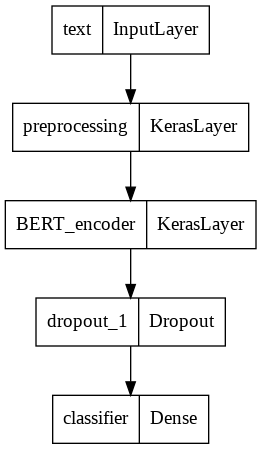

In [38]:
tf.keras.utils.plot_model(classifier_model)

#### model traininig

In [40]:
# loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()


In [60]:
print(train_ds.dtypes)
tf.convert_to_tensor(train_ds)

id              int64
description    object
jobflag         int64
dtype: object


ValueError: ignored

In [50]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr = init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

AttributeError: ignored

In [49]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

NameError: ignored

In [51]:
print(f'Training model with {tfhub_handle_encoder}')
hitsotry = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1


RuntimeError: ignored

### Predicting